# Lab 9: Variational Autoencoders

Patcharporn Sirimom, 62070507208<br>

![alt text](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)





## Lab Instruction: Generate Random Handwriting Number

In this lab, you will learn do the generative model using variational autoencoder to generate random image.</br>

This is what we are going to do in this lab: https://www.siarez.com/projects/variational-autoencoder </br>
About the variational autoencoder: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

This lab, we created model using functional API > https://keras.io/models/model/ 

### Autoencoder Model

![alt text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)


***Images from:<br>***
*1. <a href=https://blog.keras.io/building-autoencoders-in-keras.html> Keras Blog </a></br>*
*2. Manning - Deep Learning with Python Book*


In [1]:
# Import required libraries
import keras
from keras import models
from keras import layers
from keras import backend as K
from keras import callbacks

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.model_selection import train_test_split

%matplotlib inline

### Load MNIST data 

In [2]:
# Load MNIST data
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Data exploration: Shape
x_train.shape

(60000, 28, 28)

In [4]:
# Data exploration: Data type
x_train.dtype

dtype('uint8')

In [5]:
# Min, Max value
np.min(x_train),np.max(x_train)

(0, 255)

### Preprocess data 

In [6]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_train = x_train/255.

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_test = x_test/255.

In [7]:
# shape after preprocess
x_train.shape

(60000, 28, 28, 1)

### Split Train, Test, Validation data 

In [8]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,
                                                  test_size=0.1,
                                                  stratify=y_train,
                                                  random_state=0)

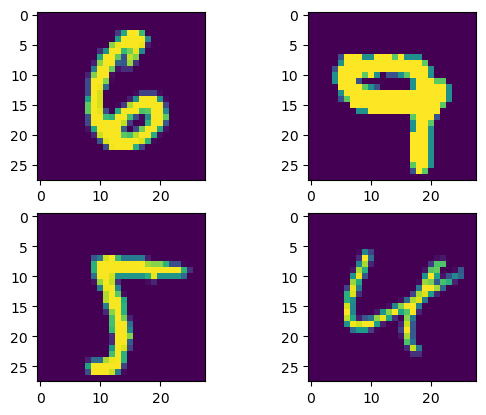

In [9]:
## Plot some image
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[43][:,:,0])
plt.subplot(222)
plt.imshow(x_train[430][:,:,0])
plt.subplot(223)
plt.imshow(x_train[4300][:,:,0])
plt.subplot(224)
plt.imshow(x_train[43000][:,:,0])
plt.show()

### Create variational autoencoder model 

In technical terms, here’s how a VAE works:
1. An encoder module turns the input samples input_img into two parameters in a latent space of representations, z_mean and z_log_variance.
2. You randomly sample a point z from the latent normal distribution that’s assumed to generate the input image, via
> z= z_mean+exp(z_log_variance)* epsilon, *where epsilon is a random tensor of small values.*
3. A decoder module maps this point in the latent space back to the original input image.

In [10]:
# Define variables
input_shape=(28,28,1)
batch_size=16
latent_dim=2 # 2 latent vector to represent MNIST data

In [11]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Encoder Model
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

In [13]:
# Variation Parameters
conv_shape = K.int_shape(x) # Shape of conv to be provided to decoder
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x) # Mean values of encoded input
z_log_var = Dense(latent_dim)(x) # Std dev. of encoded input

In [14]:
# Sampling distribution funtion
def sampling(arg):
    z_mean, z_log_var = arg
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [15]:
# Distribution function sampling layer
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [16]:
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

To define a deconvolution layer
> ```layers.Conv2DTranspose( )```

See: https://keras.io/layers/convolutional/ Search for ```Conv2DTranspose```

In [17]:
# Decoder model
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

In [18]:
decoder = Model(decoder_input, x, name='decoder')
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [19]:
# apply the decoder to the latent sample 
z_decoded = decoder(z)

In [20]:
# Wrap up encoder model
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [21]:
# Wrap up decoder model
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

The parameters of a VAE are trained via two loss functions: 
1. A reconstruction loss that forces the decoded samples to match the initial inputs.
2. A regularization loss (The Kullback-Liebler divergence) that helps learn well-formed latent spaces and reduce overfitting to the training data.

In [22]:
def vae_loss(x, z_decoded):
    xent_loss = K.binary_crossentropy(x, z_decoded)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### Compile and Summarise Model

In [23]:
## VAE Model
vae = Model(input_img, z_decoded, name='vae')
vae.add_loss(vae_loss(input_img,z_decoded))
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

In [24]:
# Plot training history
def viz_loss(history): 
    
    # Print the result from the last epoch
    print('Last Training set loss: %s'%history.history['loss'][-1])
    print('Last Validation set loss: %s'%history.history['val_loss'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)   
    
    plt.plot(epochs, loss, 'c--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

### Training The VAE Model

In [25]:
# Define callback for checkpoint 
checkpoint = callbacks.ModelCheckpoint(filepath='./logs', verbose=1, save_best_only=True) 
#xxxxxxxxx make file path to keep logs

In [26]:
# Define callback for Tensorboard
tensorboard = callbacks.TensorBoard(log_dir='./logs')
#in xxxxxxxxx path make logs folder to keeps log 

To call a Tensorboard, open terminal and type
>``` tensorboard --logdir=/full_path_to_your_logs ```

In [27]:
# Train model
history = vae.fit(x_train,x_train, epochs = 10, batch_size = batch_size, validation_split = 0.2, callbacks=[checkpoint,tensorboard])

Epoch 1/10
2700/2700 [==============================] - ETA: 0s - loss: 0.2684
Epoch 1: val_loss improved from inf to 0.26315, saving model to .\logs


INFO:tensorflow:Assets written to: .\logs\assets


INFO:tensorflow:Assets written to: .\logs\assets


2700/2700 [==============================] - 37s 13ms/step - loss: 0.2684 - val_loss: 0.2632
Epoch 2/10
2699/2700 [============================>.] - ETA: 0s - loss: 0.2633
Epoch 2: val_loss did not improve from 0.26315
2700/2700 [==============================] - 34s 12ms/step - loss: 0.2633 - val_loss: 0.2634
Epoch 3/10
2698/2700 [============================>.] - ETA: 0s - loss: 0.2632
Epoch 3: val_loss improved from 0.26315 to 0.26309, saving model to .\logs


INFO:tensorflow:Assets written to: .\logs\assets


INFO:tensorflow:Assets written to: .\logs\assets


2700/2700 [==============================] - 36s 13ms/step - loss: 0.2632 - val_loss: 0.2631
Epoch 4/10
2700/2700 [==============================] - ETA: 0s - loss: 0.2631
Epoch 4: val_loss did not improve from 0.26309
2700/2700 [==============================] - 32s 12ms/step - loss: 0.2631 - val_loss: 0.2635
Epoch 5/10
2695/2700 [============================>.] - ETA: 0s - loss: 0.2631
Epoch 5: val_loss improved from 0.26309 to 0.26295, saving model to .\logs


INFO:tensorflow:Assets written to: .\logs\assets


INFO:tensorflow:Assets written to: .\logs\assets


2700/2700 [==============================] - 34s 13ms/step - loss: 0.2631 - val_loss: 0.2630
Epoch 6/10
2698/2700 [============================>.] - ETA: 0s - loss: 0.2631
Epoch 6: val_loss did not improve from 0.26295
2700/2700 [==============================] - 31s 12ms/step - loss: 0.2630 - val_loss: 0.2633
Epoch 7/10
2696/2700 [============================>.] - ETA: 0s - loss: 0.2630
Epoch 7: val_loss improved from 0.26295 to 0.26295, saving model to .\logs


INFO:tensorflow:Assets written to: .\logs\assets


INFO:tensorflow:Assets written to: .\logs\assets


2700/2700 [==============================] - 34s 13ms/step - loss: 0.2630 - val_loss: 0.2629
Epoch 8/10
2698/2700 [============================>.] - ETA: 0s - loss: 0.2630
Epoch 8: val_loss did not improve from 0.26295
2700/2700 [==============================] - 31s 12ms/step - loss: 0.2630 - val_loss: 0.2631
Epoch 9/10
2697/2700 [============================>.] - ETA: 0s - loss: 0.2630
Epoch 9: val_loss did not improve from 0.26295
2700/2700 [==============================] - 36s 13ms/step - loss: 0.2630 - val_loss: 0.2632
Epoch 10/10
2699/2700 [============================>.] - ETA: 0s - loss: 0.2630
Epoch 10: val_loss improved from 0.26295 to 0.26287, saving model to .\logs


INFO:tensorflow:Assets written to: .\logs\assets


INFO:tensorflow:Assets written to: .\logs\assets


2700/2700 [==============================] - 45s 17ms/step - loss: 0.2630 - val_loss: 0.2629


Last Training set loss: 0.26299744844436646
Last Validation set loss: 0.26287487149238586


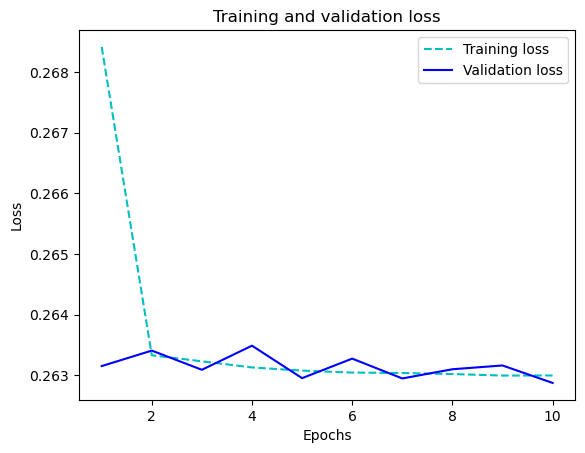

In [28]:
# Visualize loss
viz_loss(history)

In [29]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 35896), started 2:45:03 ago. (Use '!kill 35896' to kill it.)

### Predicting on Test Datast 

In [37]:
# Define visualized image function
def visualize_image(image, row=3, col=10, title='Generated hadwriting digit image with VAE'):
    fig, ax = plt.subplots(row,col,figsize=(13,4))
    fig.suptitle(title)
    for i in range(row):
        for j in range(col):
            ax[i,j].imshow(image[j + i*10],cmap='gray')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)

In [38]:
# Reconstruct image using test dataset
decoded_imgs = vae.predict(x_test)

313/313 [==============================] - 2s 5ms/step


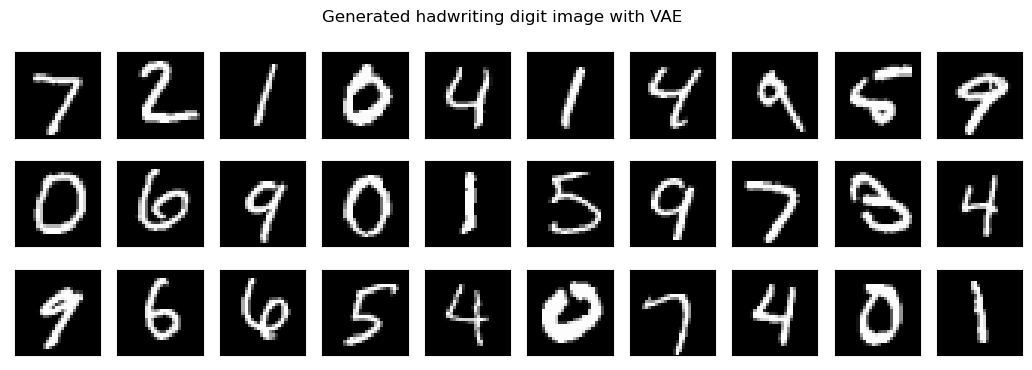

In [39]:
# Show test image
x_test_reshape = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])
visualize_image(x_test_reshape)

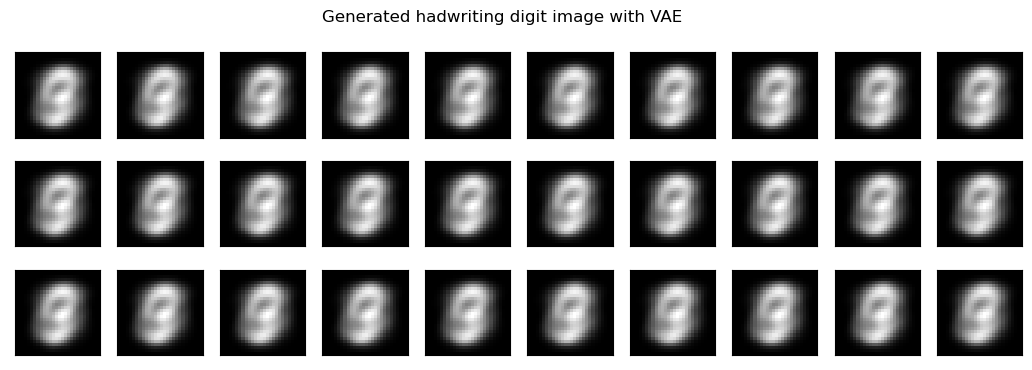

In [40]:
# Show reconstruct image
decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],decoded_imgs.shape[1],decoded_imgs.shape[2])
visualize_image(decoded_imgs)

### Try Randomly Generate Data

In [41]:
# Randomly generate a latent vector
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

random_input = np.random.uniform(high=2,low=-2,size=(64,latent_dim))

# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = vae.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit

# plt.figure(figsize=(10, 10))
# plt.imshow(figure, cmap='Greys_r')
# plt.show()

In [ ]:
# Reconstruct image


In [ ]:
# Exploration: X_decode's shape


In [ ]:
# Reshape x_decode
decode_digit = x_decoded.reshape(64,digit_size, digit_size)

### Show Generated Image

In [ ]:
# Show reconstruct image
visualize_image(decode_digit)

### Scan The Latent Space

In [ ]:
# Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 5e-4
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Visualize Latent Space 

The colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

In [43]:
# Estimate latent space from test set
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

625/625 [==============================] - 2s 3ms/step


In [44]:
# Define latent space visualizatio function
def show_latent_space(encoded_imgs):
    plt.figure(figsize=(10, 8))
    plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], 
                c=y_test,alpha=.7, s=3**2, cmap='viridis')
    plt.colorbar()
    plt.show()

In [45]:
# Show latent space
show_latent_space(x_test_encoded)

TypeError: list indices must be integers or slices, not tuple

<Figure size 1000x800 with 0 Axes>

# Discussion


Write down why you design this architecture or why you choose this set of parameter</br>
You should have at least 1 different architectures/set of hyperparameters per person in your team</br>
*Note: For the last step, please turn off a verbose during training

# [Optional] To play further with image generation
You can try variational autoencoder model with the following dataset: </br>
1. Cat & Dog https://www.kaggle.com/c/dogs-vs-cats/data </br>
2. Celebrity image (for those who have high computational power) http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html</br>

### More on Autoencoder Model

Autoencoder tutorial: 
1. https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial
2. https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

